In [424]:
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
from numpy import nan as NA
from collections import Counter
from matplotlib import pyplot as plt
import math

In [425]:
file = open("EuCitiesTemperatures.csv")
plt.style.use('seaborn-v0_8-darkgrid')
eucities = pd.read_csv(file)
eucities

,city,country,population,EU,coastline,latitude,longitude,temperature
0,Elbasan,Albania,2.90,no,yes,41.12,20.08,15.18
1,Andorra,Andorra,0.07,no,no,42.50,1.52,NaN
2,Innsbruck,Austria,8.57,yes,no,NaN,11.41,4.54
3,Graz,Austria,8.57,yes,no,47.08,NaN,6.91
4,Linz,Austria,8.57,yes,no,48.32,14.29,6.79
...,...,...,...,...,...,...,...,...
208,Edinburgh,United Kingdom,65.11,yes,yes,55.95,NaN,NaN
209,Exeter,United Kingdom,65.11,yes,yes,50.70,-3.53,10.14
210,Inverness,United Kingdom,65.11,yes,yes,NaN,-4.23,8.00
211,Glasgow,United Kingdom,65.11,yes,yes,55.87,-4.25,8.60


From looking at what is printed, there are some NaN's in latitude, longitude, and temperature. There might be NaN's in other columns too. Let's check that.

In [427]:
eucities.isnull().any()

city           False
country        False
population     False
EU             False
coastline      False
latitude        True
longitude       True
temperature     True
dtype: bool

We will start by replacing the NaN's in latitude and longitude, by filling in them with means by country. There are reasons to do this and reasons not to do this. One reason not to do this is that the average latitude and longitude might not sit inside the country if the cities are placed just so and the country isn't convex (for example, Italy).

For now, we won't worry about that. We ultimately want to do some modeling and analysis with temperature and population, and replacing the NaN's in this way will be a good-enough approximation to do the modeling and analysis - i.e., the modeling will not be sensitive to whether the coordinates of a city actually lie within a country, just a general location is fine.

In [428]:
mean_coords = eucities.groupby('country')['latitude'].mean().round(2)
eucities['latitude'] = eucities['latitude'].fillna(eucities['country'].map(mean_coords))
mean_coords = eucities.groupby('country')['longitude'].mean().round(2)
eucities['longitude'] = eucities['longitude'].fillna(eucities['country'].map(mean_coords))

To get a sense of the dataset, we will divide Europe semi-arbitrarily by longitude into three regions: western, central, and eastern. We want to see which region is most represented in the dataset. Here is the breakdown of which countries have cities in each region. A country can appear in more than one region.

In [429]:
filtered_cities = eucities[eucities['longitude'].between(-10,8)]
print('Western countries: ',', '.join(filtered_cities['country'].unique()))
filtered_cities = eucities[eucities['longitude'].between(8,17)]
print('Central countries: ',', '.join(filtered_cities['country'].unique()))
filtered_cities = eucities[eucities['longitude'].between(17,40)]
print('Eastern countries: ',', '.join(filtered_cities['country'].unique()))

Western countries:  Andorra, Belgium, France, Germany, Ireland, Netherlands, Norway, Portugal, Spain, Switzerland, United Kingdom
Central countries:  Austria, Bosnia and Herzegovina, Croatia, Czech Republic, Denmark, Germany, Italy, Norway, Poland, Slovenia, Sweden, Switzerland
Eastern countries:  Albania, Belarus, Bulgaria, Estonia, Finland, Greece, Hungary, Latvia, Lithuania, Macedonia, Moldova, Montenegro, Poland, Romania, Serbia, Slovakia, Sweden, Turkey, Ukraine


By inspection, these divisions aren't perfect, but they are roughly accurate. Here is a bar chart to compare how much these regions are represented in the dataset.

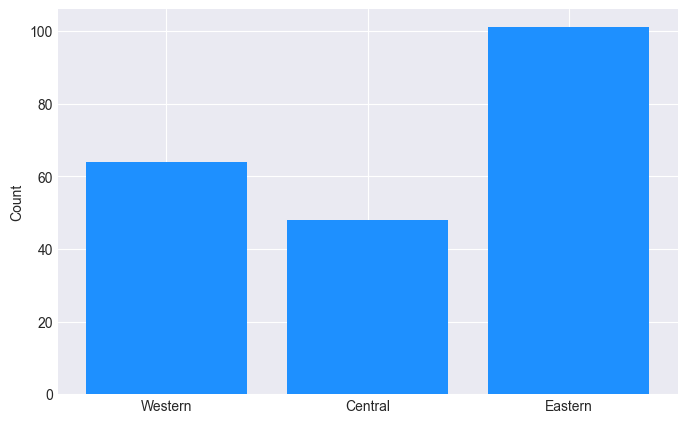

In [431]:
sizes = []
sizes.append(eucities[eucities['longitude']<8].shape[0])
sizes.append(eucities[(eucities['longitude']>=8) &(eucities['longitude']<17)].shape[0])
sizes.append(eucities[eucities['longitude']>=17].shape[0])

categories = ['Western','Central','Eastern']
plt.figure(figsize=(8,5))
plt.bar(categories, sizes,color='dodgerblue')
plt.ylabel("Count")
plt.show()

Eastern Europe is the most represented in the dataset, followed by western Europe, followed by central Europe. This is just a rough look, and the divisions are rough, but it might be good to know that eastern Europe has more cities in the dataset than other regions, probably because it also has more countries, and also because of how Europe is shaped.

Let's look at how the dataset is broken down by population.

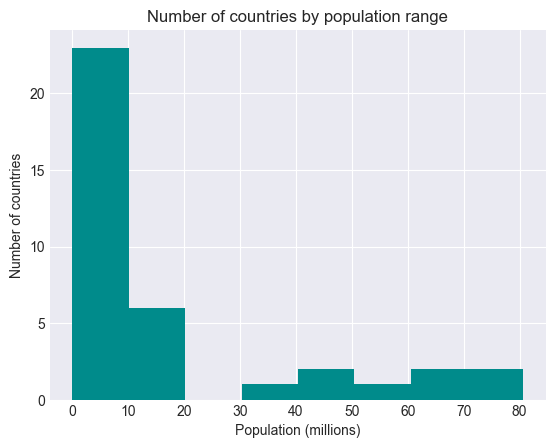

In [444]:
maxpopulation = eucities['population'].max()
uniquecountrydict = {}
for i in range(len(eucities)):
    if not eucities.at[i, 'country'] in uniquecountrydict.keys():
        uniquecountrydict[eucities.at[i, 'country']] = eucities.at[i, 'population']

fig, ax = plt.subplots(1, 1)

plt.hist(uniquecountrydict.values(),bins=8,color='darkcyan')
ax.set_title("Number of countries by population range")
ax.set_xlabel('Population (millions)')
ax.set_ylabel('Number of countries')
plt.show()

The main task we will take up is replacing the NaN's in temperature. It's not clear from the dataset whether temperature is an average, or a particular observeration. But it makes the most sense to assume it is some kind of average temperature, indicative of a city's climate, so that is what I will assume from here; later visualizations support this as well.

In [391]:
eucities[eucities['temperature'].isna()]

,city,country,population,EU,coastline,latitude,longitude,temperature
1,Andorra,Andorra,0.07,no,no,42.50,1.52,NaN
11,Hrodna,Belarus,9.48,no,no,53.68,25.64,NaN
14,Sarajevo,Bosnia and Herzegovina,3.80,no,yes,43.85,13.38,NaN
16,Burgas,Bulgaria,7.10,yes,yes,42.51,27.47,NaN
18,Ruse,Bulgaria,7.10,yes,yes,43.85,25.97,NaN
...,...,...,...,...,...,...,...,...
202,Bournemouth,United Kingdom,65.11,yes,yes,50.73,-1.90,NaN
204,Aberdeen,United Kingdom,65.11,yes,yes,53.55,-2.08,NaN
206,Bradford,United Kingdom,65.11,yes,yes,53.55,-1.75,NaN
207,Dundee,United Kingdom,65.11,yes,yes,56.47,-2.94,NaN


Of all the cities in the dataset, 64 have missing temperatures. That is a significant portion of the dataset.

To fill in these NaN's, we can be more sophisticated than we were with the latitude/longitudes and use predictive modeling. There are two options that jump out: Linear modeling and clustering.

The argument for a linear model is that it is plausible that temperature depends linearly on factors such as latitude and coastline.

The argument for clustering is that temperature of nearby cities is predictive of the temperature of a given city.

But before I get ahead of myself, let's visualize the data.

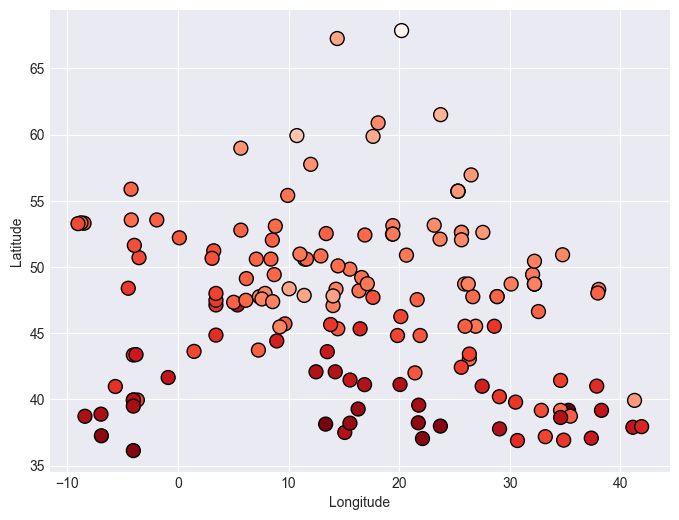

In [445]:
plt.figure(figsize=(8, 6))
plt.scatter(eucities['longitude'], eucities['latitude'], c=eucities['temperature'], cmap='Reds', edgecolors='black', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

As expected, there seems to be a strong relationship between latitude and temperature. But it also looks like there might be a relationship between longitude and temperature. Coastline might not be such a big factor.

I will try three linear models, adding one by one the variables latitude, longitude, and coastline. For each regression, I will keep aside the same test set, to help evaluate the model. Here is the first, a simple linear regression, predicting temperature as a function of latitude.


In [452]:
import sklearn
import random

import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection

eucitiesnoNaN = eucities[eucities['temperature'].notna()]
#eucitiesnoNaN = eucitiesnoNaN.reset_index()
eucitiesnoNaN['coastline'] = eucitiesnoNaN['coastline'].map({'yes':1.0,'no':0.0})
X = eucitiesnoNaN[['latitude','longitude','coastline']]
Y = eucitiesnoNaN['temperature']



x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X[['latitude']], Y, test_size=0.2, random_state=4
)
model = sklearn.linear_model.LinearRegression()
model.fit(x_train ,y_train)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(x_test))
trainr2 = sklearn.metrics.r2_score(y_train, model.predict(x_train))
testr2 = sklearn.metrics.r2_score(y_test, model.predict(x_test))
print('MSE on Test Data: ',mse,'\nTrain R^2: ',trainr2,'\nTest R^2: ',testr2)

MSE on Test Data:  5.76822594695471 
Train R^2:  0.6584987474662627 
Test R^2:  0.3330109243629251


/var/folders/p0/_rv7hyx175s58w5dhg463z8w0000gn/T/ipykernel_23312/3585741672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucitiesnoNaN['coastline'] = eucitiesnoNaN['coastline'].map({'yes':1.0,'no':0.0})


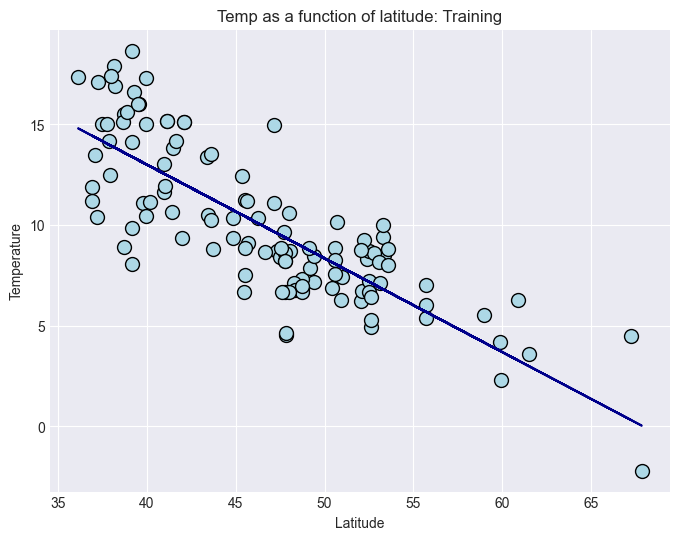

In [453]:
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(35, 70, step=5))
plt.yticks(np.arange(-5,20,step=5))
plt.scatter(x_train, y_train, c='lightblue', edgecolors='black', s=100)
plt.plot(x_train, model.coef_*x_train + model.intercept_, color='darkblue')
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title('Temp as a function of latitude: Training')
plt.grid(True)
plt.show()

The line looks like a good a fit on the training data. As expected: Of course temperature will go down as latitude gets higher.

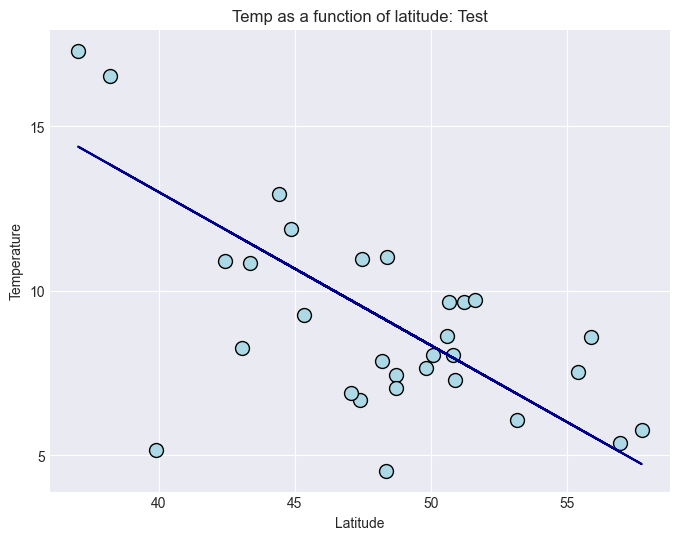

In [454]:
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(35, 70, step=5))
plt.yticks(np.arange(-5,20,step=5))
plt.scatter(x_test, y_test, c='lightblue', edgecolors='black', s=100)
plt.plot(x_test, model.coef_*x_test + model.intercept_, color='darkblue')
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title('Temp as a function of latitude: Test')
plt.grid(True)
plt.show()

On the test data, the line isn't as good of a fit. This is evident in the test R^2 as well. It might be bad luck that the test set is more scattered than the training set.

Next, we try adding longitude to the model.

In [455]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X[['latitude','longitude']], Y, test_size=0.2, random_state=4
)
model = sklearn.linear_model.LinearRegression()
model.fit(x_train,y_train)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(x_test))
trainr2 = sklearn.metrics.r2_score(y_train, model.predict(x_train))
testr2 = sklearn.metrics.r2_score(y_test, model.predict(x_test))
print('MSE on Test Data: ',mse,'\nTrain R^2: ',trainr2,'\nTest R^2: ',testr2)


MSE on Test Data:  4.3519617864808895 
Train R^2:  0.7173505156640425 
Test R^2:  0.4967757858540154


There is a modest improvement on the training data and a significant improvement on test data.

In [456]:
print('Coefficients: ',model.coef_,'Intercept: ',model.intercept_)

Coefficients:  [-0.48468412 -0.07036772] Intercept:  33.71985521422704


Nothing out of the ordinary, but it is clear that latitude has more predictive power, although we should account for the fact that longitude takes on a larger range of values:

In [460]:
print('Latitude range: ',eucities['latitude'].max()-eucities['latitude'].min(),'Longitude range',eucities['longitude'].max()-eucities['longitude'].min())

Latitude range:  31.71999999999999 Longitude range 50.980000000000004


In [461]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=0
)
model = sklearn.linear_model.LinearRegression()
model.fit(x_train,y_train)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(x_test))
trainr2 = sklearn.metrics.r2_score(y_train, model.predict(x_train))
testr2 = sklearn.metrics.r2_score(y_test, model.predict(x_test))
print('MSE on Test Data: ',mse,'\nTrain R^2: ',trainr2,'\nTest R^2: ',testr2)
print('Coefficients: ',model.coef_,'Intercept: ',model.intercept_)


MSE on Test Data:  2.660731979473037 
Train R^2:  0.707987354744326 
Test R^2:  0.777995826790587
Coefficients:  [-0.45810658 -0.07322555  1.5247259 ] Intercept:  31.15080482533302


The train R^2 went down a bit, but the test R^2 went up a lot. What do we make of that? Also, I encoded yes as 1, and no as 0. So with these coefficients, the model will assign a temperature that is 1.5247 higher if there is a coastline. This is unexpected, because I would expect coastal cities to be cooler than non-coastal cities, all else equal. But some inspection reveals that for one, most cities in the dataset are marked to have coastline, and moreover, the coastline statistic is "yes" if the country the city is in has a coastline, not the city has a coastline:

In [406]:
eucities.groupby('coastline').count()

,city,country,population,EU,latitude,longitude,temperature
coastline,,,,,,,
no,30,30,30,30,30,30,25
yes,183,183,183,183,183,183,124


In [407]:
coastline_counts = eucities.groupby('country')['coastline'].nunique()
morethan1coastlinevalue = coastline_counts[coastline_counts>1]
print('Number of countries with more than one value for coastline: ',morethan1coastlinevalue.shape[0])

Number of countries with more than one value for coastline:  0


With all of this in mind, I think that coastline will be mostly noise when trying to predict temperature, and the test R^2 going up is just noise, partly from the test set being small and maybe not representative. Let's try a regression with coastline and temperature and see what happens:

In [462]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X[['coastline']], Y, test_size=0.2, random_state=0
)
model = sklearn.linear_model.LinearRegression()
model.fit(x_train ,y_train)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(x_test))
trainr2 = sklearn.metrics.r2_score(y_train, model.predict(x_train))
testr2 = sklearn.metrics.r2_score(y_test, model.predict(x_test))
print('MSE on Test Data: ',mse,'\nTrain R^2: ',trainr2,'\nTest R^2: ',testr2)

MSE on Test Data:  10.658611655413567 
Train R^2:  0.0630689002588728 
Test R^2:  0.11067469915216988


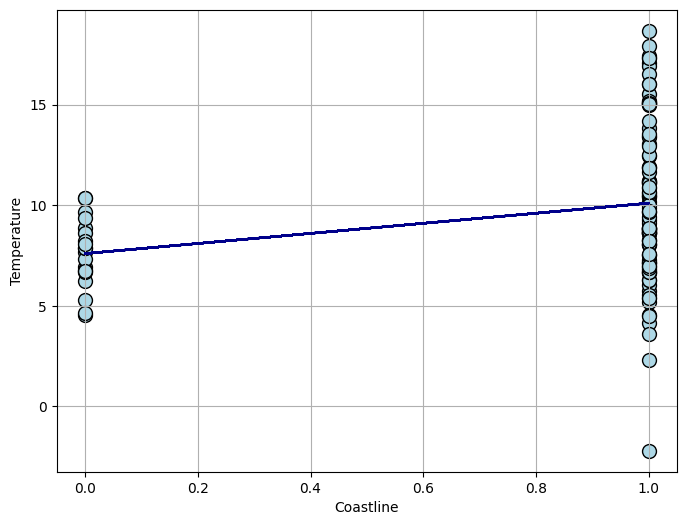

In [409]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, c='lightblue', edgecolors='black', s=100)
plt.plot(x_train, model.coef_*x_train + model.intercept_, color='darkblue')
plt.xlabel('Coastline')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

So it seems to me like the large increase in test R^2 is unlikely to be caused by the explanatory power of the coastline variable. I think the train R^2 going down says something, and I don't think these results let us dispense the hypothesis that coastline is noise when predicting temperature. Let's put this on the back burner for now and try clustering, and see if we get dramatically different results.

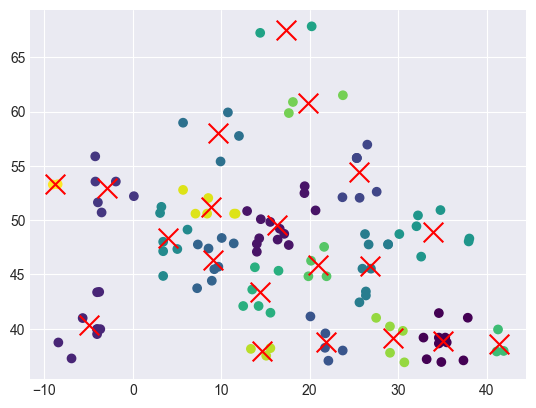

In [463]:
import sklearn.cluster
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X[['longitude','latitude']], Y, test_size=0.2, random_state=0
)
kmeans = sklearn.cluster.KMeans(n_clusters=20, random_state=0, n_init='auto')
kmeans.fit(x_train)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.scatter(x_train['longitude'], x_train['latitude'], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='red')
plt.show()

In [464]:
x_train['cluster'] = kmeans.fit_predict(x_train[['latitude', 'longitude']])
df = eucities.merge(x_train,left_index=True,right_index=True, how='inner')
cluster_avg_temp = df.groupby('cluster')['temperature'].mean().to_dict()
df['predicted_temp'] = df['cluster'].map(cluster_avg_temp)
trainr2 = sklearn.metrics.r2_score(df['temperature'], df['predicted_temp'])

x_test['cluster'] = kmeans.fit_predict(x_test[['latitude', 'longitude']])
df = eucities.merge(x_test,left_index=True,right_index=True, how='inner')
cluster_avg_temp = df.groupby('cluster')['temperature'].mean().to_dict()
df['predicted_temp'] = df['cluster'].map(cluster_avg_temp)
mse = sklearn.metrics.mean_squared_error(df['temperature'], df['predicted_temp'])
testr2 = sklearn.metrics.r2_score(df['temperature'], df['predicted_temp'])
print("Test Mean Squared Error:", mse)
print("Train R^2: ", trainr2)
print("Test R^2: ",testr2)


Test Mean Squared Error: 0.9096855555555557
Train R^2:  0.7777073895142892
Test R^2:  0.924098334142752


The results with clustering on the training and test data are good. The test R^2 is great, but due to the small test size I'm not sure if we should read into that too much. But the train R^2 beats the train R^2 of the regressions. It makes intuitive sense that this would give good results, and that temperature of nearby cities will predict the temperature of a given city. Let's use this model to fill in the missing temperature data in the original eucities dataset.

In [465]:
eucities['cluster'] = kmeans.fit_predict(eucities[['latitude', 'longitude']])
cluster_avg_temp = eucities.groupby('cluster')['temperature'].mean().to_dict()
eucities['predicted_temp'] = eucities['cluster'].map(cluster_avg_temp).round(2)
eucities['temperature'] = eucities['temperature'].fillna(eucities['predicted_temp'])
eucities

,city,country,population,EU,coastline,latitude,longitude,temperature,cluster,predicted_temp
0,Elbasan,Albania,2.90,no,yes,41.12,20.08,15.18,8,15.36
1,Andorra,Andorra,0.07,no,no,42.50,1.52,12.17,1,12.17
2,Innsbruck,Austria,8.57,yes,no,47.85,11.41,4.54,11,7.44
3,Graz,Austria,8.57,yes,no,47.08,14.02,6.91,4,8.65
4,Linz,Austria,8.57,yes,no,48.32,14.29,6.79,4,8.65
...,...,...,...,...,...,...,...,...,...,...
208,Edinburgh,United Kingdom,65.11,yes,yes,55.95,-2.94,8.47,7,8.47
209,Exeter,United Kingdom,65.11,yes,yes,50.70,-3.53,10.14,18,10.04
210,Inverness,United Kingdom,65.11,yes,yes,53.55,-4.23,8.00,7,8.47
211,Glasgow,United Kingdom,65.11,yes,yes,55.87,-4.25,8.60,7,8.47


We have successfully predicted the missing temperatures. Let's plot it and hope that the results look okay:

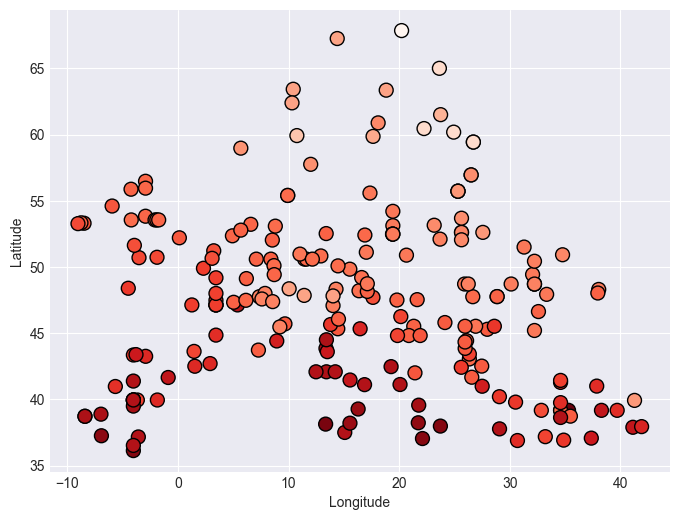

In [466]:
plt.figure(figsize=(8, 6))
plt.scatter(eucities['longitude'], eucities['latitude'], c=eucities['temperature'], cmap='Reds', edgecolors='black', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

This passes the eye test - for the most part, the temperatures vary in the way we'd expect. There are some data points that are different colors than their neighbors. That in itself doesn't mean that the model has failed, since actual temperatures don't behave perfectly. The temperatures that have been inputted can be used for further analysis and modeling.